In [1]:
import os
import mujoco
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, DummyVecEnv
from stable_baselines3.common.monitor import Monitor, load_results
import matplotlib.pyplot as plt
from src import render_model_gym
from datetime import datetime
import importlib
from src import render_model_gym


from src.definitions import PROJECT_ROOT, enforce_absolute_path
from src import helpers
import src.lucy_classes_v1 as lucy
from src.helpers import generate_paths_monitor_model

importlib.reload(lucy)

<module 'src.lucy_classes_v1' from 'c:\\GitHub\\training-lucy\\src\\lucy_classes_v1.py'>

In [2]:
# Configuration
n_envs = 7
xml_path = enforce_absolute_path("animals/lucy_v3.xml")


def new_vec_env(env: lucy.LucyEnv, monitor_dir: str):
    return make_vec_env(
        env,
        n_envs=n_envs,
        vec_env_cls=SubprocVecEnv,
        monitor_dir=monitor_dir,
    )


print(f"MuJoCo version: {mujoco.__version__}")

# Verify Lucy model loads
model = mujoco.MjModel.from_xml_path(xml_path)
data = mujoco.MjData(model)
print(
    f"Lucy model loaded: {model.nq} qpos dims, {model.nv} qvel dims, {model.nu} actuators"
)
print(f"Observation space will be: {model.nq - 2 + model.nv} dims (qpos[2:] + qvel)")

sim_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")




MuJoCo version: 3.4.0
Lucy model loaded: 57 qpos dims, 48 qvel dims, 42 actuators
Observation space will be: 103 dims (qpos[2:] + qvel)


Episode terminated during frame collection.


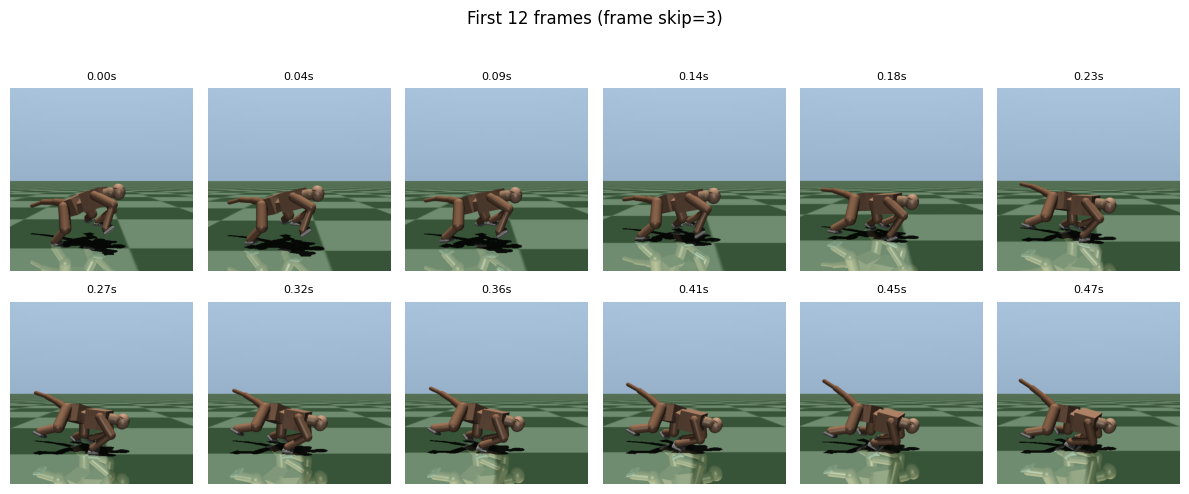

,time,reward,forward_velocity,chest_height,ctrl_cost,x_position,max_episode_seconds,sensors,height_dict,total_height_reward,...,head_direction_reward,head_direction_angle,leg_pos_reward,leg_pos_details,straight_tail_reward,straight_tail_details,body_contacts,contact_penalty,fall_penalty,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.045,2.759604,0.323036,0.205352,0.004016,-0.123321,10.0,{},"{'chest': {'height': 0.20535210471026993, 'rew...",7.000000e-01,...,0.118655,12.089646,0.510954,"{'front_left': {'thigh': 0.8801378996947332, '...",-0.054292,"{'straight_score': 0.992526994340004, 'actuati...",0.0,0.0,0.0,4.214333
2,0.090,2.046457,0.296556,0.194704,0.003365,-0.109523,10.0,{},"{'chest': {'height': 0.19470359033837367, 'rew...",3.506683e-03,...,0.120088,11.994153,0.515322,"{'front_left': {'thigh': 0.8993835829501652, '...",-0.100236,"{'straight_score': 0.9925114998703201, 'actuat...",0.0,0.0,0.0,11.728308
3,0.135,0.093309,0.390754,0.166736,0.004065,-0.095317,10.0,{},"{'chest': {'height': 0.1667358265056913, 'rewa...",2.504096e-15,...,0.116923,12.205150,0.516557,"{'front_left': {'thigh': 0.9079161559962802, '...",-0.020395,"{'straight_score': 0.9933589181587852, 'actuat...",1.0,-2.0,0.0,16.026544
4,0.180,0.116609,0.557779,0.144918,0.003337,-0.069309,10.0,{},"{'chest': {'height': 0.1449183382942733, 'rewa...",1.014707e-24,...,0.093463,13.769141,0.505302,"{'front_left': {'thigh': 0.9502863407932413, '...",0.013977,"{'straight_score': 0.9939151354495307, 'actuat...",1.0,-2.0,0.0,16.270281
5,0.225,2.019843,0.417043,0.144253,0.003342,-0.048498,10.0,{},"{'chest': {'height': 0.14425337105427763, 'rew...",6.944424e-22,...,0.054078,16.394778,0.492373,"{'front_left': {'thigh': 0.9766591292850307, '...",-0.037933,"{'straight_score': 0.9943773240081644, 'actuat...",0.0,0.0,0.0,20.334418
6,0.270,1.956252,0.383406,0.139021,0.002550,-0.030936,10.0,{},"{'chest': {'height': 0.13902066796669763, 'rew...",8.808140e-21,...,0.007832,19.477886,0.473080,"{'front_left': {'thigh': 0.9872367963940742, '...",-0.033792,"{'straight_score': 0.9936880202472606, 'actuat...",0.0,0.0,0.0,26.178403
7,0.315,1.949914,0.314910,0.134041,0.003192,-0.015477,10.0,{},"{'chest': {'height': 0.13404091940830934, 'rew...",4.065002e-21,...,0.000000,22.060307,0.454010,"{'front_left': {'thigh': 0.9925240963026475, '...",-0.047332,"{'straight_score': 0.9924452225345057, 'actuat...",0.0,0.0,0.0,32.039733
8,0.360,1.936492,0.263473,0.129052,0.002960,-0.002945,10.0,{},"{'chest': {'height': 0.1290518428749894, 'rewa...",2.511314e-22,...,0.000000,24.718957,0.440125,"{'front_left': {'thigh': 0.9938521069498717, '...",-0.054728,"{'straight_score': 0.9917106950564714, 'actuat...",0.0,0.0,0.0,37.843844
9,0.405,1.810543,0.053172,0.125258,0.003861,0.001951,10.0,{},"{'chest': {'height': 0.12525790594681707, 'rew...",3.507776e-22,...,0.000000,28.110359,0.425509,"{'front_left': {'thigh': 0.9914570251622805, '...",-0.120638,"{'straight_score': 0.9910614404066976, 'actuat...",0.0,0.0,0.0,39.381944


In [3]:
importlib.reload(lucy)
importlib.reload(render_model_gym)

standing_monitor_path, standing_model_path = generate_paths_monitor_model(
    "standing_model"
)


def make_env(render_mode="None", *args, **kwargs):
    return lucy.LucyStandingWrapper(
        lucy.LucyEnv(
            xml_file=xml_path, render_mode=render_mode, max_episode_seconds=10,
        
        ),
            body_contact_penalty=-2
    )

standing_attrs = [
    "chest_height",
    "forward_velocity",
    "total_height_reward",
    "head_direction_reward",
    "leg_pos_reward",
    "straight_tail_reward",
]

env = make_env(render_mode="rgb_array")

df = render_model_gym.display_test_env(
    env,
    max_frames=21,
    frame_skip=3,
    attr_keys='all',
)
plt.show()
df

In [4]:
standing_vec_env = new_vec_env(make_env, standing_monitor_path)

print(f"Created {n_envs} parallel standing environments")
print(f"Logging to: {standing_monitor_path}")

standing_model = PPO(
    policy="MlpPolicy",
    env=standing_vec_env,
    verbose=1,
    device="cpu",
    n_steps=2048,
    batch_size=256,
    n_epochs=4,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.02,
    learning_rate=2e-4,
    target_kl=0.03,
    policy_kwargs=dict(
        net_arch=dict(
            pi=[512, 512], vf=[512, 512]
        )
    ),
)

# Train for standing (shorter since simpler task)
STANDING_TIMESTEPS = 2_000_000
print(f"Training standing policy for {STANDING_TIMESTEPS:,} timesteps...")
standing_model.learn(total_timesteps=STANDING_TIMESTEPS)

Created 7 parallel standing environments
Logging to: C:\GitHub\training-lucy\logs\standing_model_2026-01-11_12-15
Using cpu device
Training standing policy for 2,000,000 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 61       |
|    ep_rew_mean     | -50.3    |
| time/              |          |
|    fps             | 3528     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 14336    |
---------------------------------
Early stopping at step 1 due to reaching max kl: 0.05
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 60.1       |
|    ep_rew_mean          | -50.4      |
| time/                   |            |
|    fps                  | 3374       |
|    iterations           | 2          |
|    time_elapsed         | 8          |
|    total_timesteps      | 28672      |
| train/                  |            |
|    approx_k

Stable standing model at: Standing model saved to: `C:\GitHub\training-lucy\trained_models\lucy_v2_standing_model_2026-01-11_09-04`

In [5]:

standing_model.save(standing_model_path)
print(f"Standing model saved to: {standing_model_path}")

Standing model saved to: C:\GitHub\training-lucy\trained_models\standing_model_2026-01-11_12-15


In [8]:
render_model_gym.render_model_gym(standing_model_path, xml_path)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Simulation dt: 0.0150s per step
Running simulation at 1.0x speed... Close the window to exit.

Stopped by user


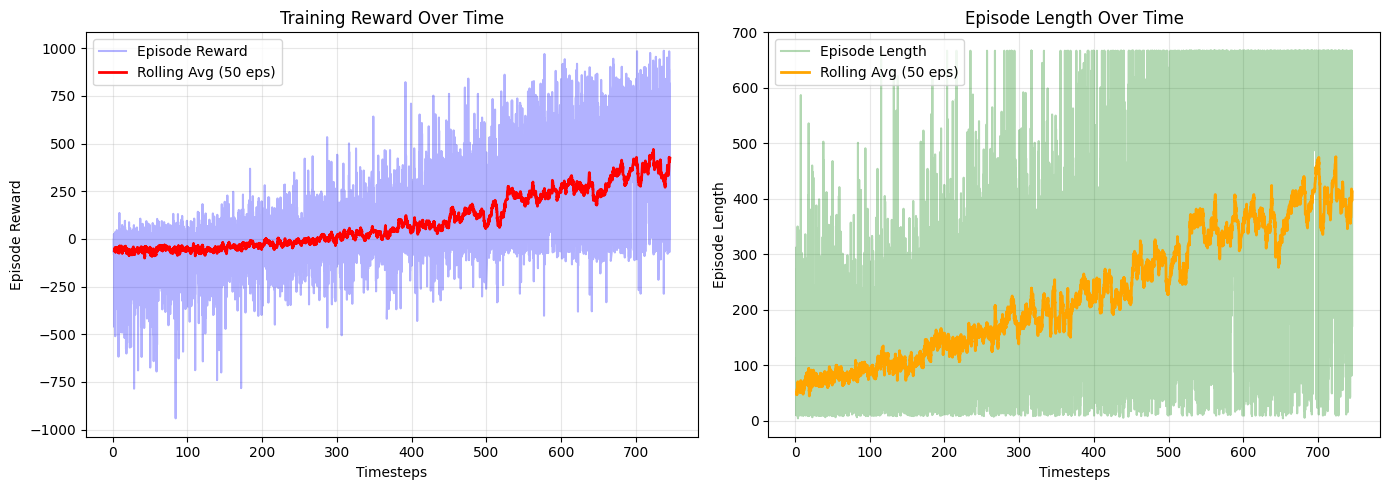

Training Summary:
Total episodes: 11968
Final avg reward (last 100 eps): 354.75
Max reward: 987.54
  Final avg length (last 100 eps): 386.3


In [9]:
standing_df = load_results(standing_monitor_path)
helpers.plot_training_progress(standing_df)
helpers.print_training_summary(standing_df)

# Walking training

Load stable standing model

In [ ]:
#standing_model_path = "C:\\GitHub\\training-lucy\\trained_models\\lucy_v2_standing_model_2026-01-11_09-04"

<>:6: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\G'
C:\Users\326po\AppData\Local\Temp\ipykernel_30488\1056296603.py:6: SyntaxWarning: invalid escape sequence '\G'
  standing_model_path = "C:\GitHub\training-lucy\trained_models\lucy_v2_standing_model_2026-01-11_09-04"


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


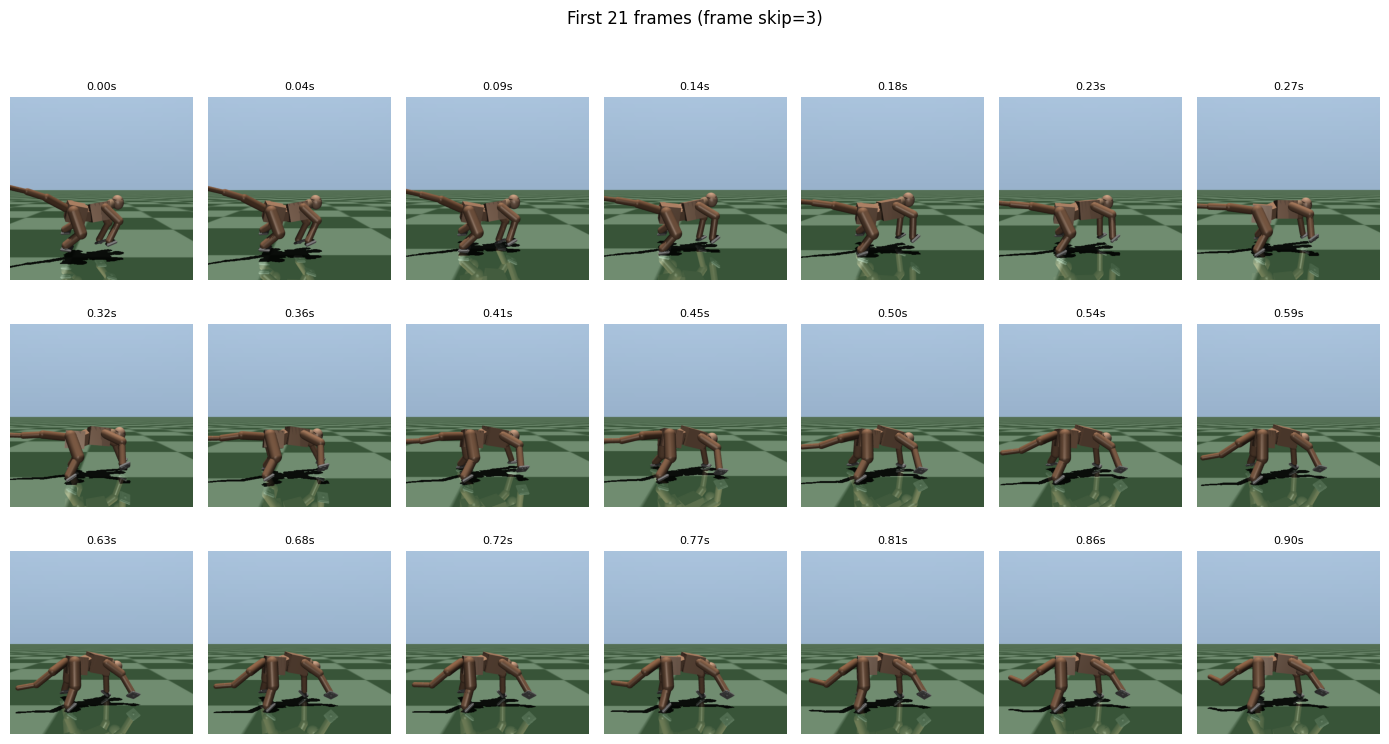

,time,chest_height,forward_velocity,forward_reward,gait_reward,stillness_reward,leg_pos_reward,height_dict,reward,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
1,0.045,0.191175,0.007290,0.006970,0.0,-0.211514,0.071860,"{'chest': {'height': 0.1911746065565426, 'rewa...",0.624597,1.976499
2,0.090,0.165677,-0.078919,-0.211468,0.0,-0.057849,0.072098,"{'chest': {'height': 0.1656768534208393, 'rewa...",0.232888,3.475721
3,0.135,0.173489,-0.240504,-0.223643,0.0,-0.045549,0.071152,"{'chest': {'height': 0.17348932206697243, 'rew...",0.232015,3.949532
4,0.180,0.184367,-0.206326,-0.205014,0.0,-0.058218,0.070699,"{'chest': {'height': 0.1843672823299535, 'rewa...",0.430959,5.247200
5,0.225,0.183210,-0.139125,-0.125499,0.0,-0.024781,0.070695,"{'chest': {'height': 0.18321026441895352, 'rew...",0.514009,6.722571
6,0.270,0.176728,-0.042687,-0.022806,0.0,-0.018266,0.071143,"{'chest': {'height': 0.1767284587001793, 'rewa...",0.622229,8.485808
7,0.315,0.172894,0.201249,0.251550,0.0,-0.025090,0.071519,"{'chest': {'height': 0.17289417025792683, 'rew...",0.703191,10.593406
8,0.360,0.175851,0.310182,0.315663,0.0,-0.021980,0.073245,"{'chest': {'height': 0.1758508378312292, 'rewa...",0.959368,13.457084
9,0.405,0.168464,0.391787,0.407708,0.0,-0.005866,0.075365,"{'chest': {'height': 0.16846439981868117, 'rew...",1.041708,16.488173


In [19]:
# Create walking training environment
importlib.reload(lucy)

if "standing_model_path" not in locals():
    print("Loading pre-trained standing model...")
    standing_model_path = "C:\GitHub\training-lucy\trained_models\lucy_v2_standing_model_2026-01-11_09-04"




walking_attrKeys = [
    "chest_height",
    "forward_velocity",
    "forward_reward",
    "gait_reward",
    "stillness_reward",
    "leg_pos_reward",
    "height_dict"
]


walking_log_dir, walking_model_path = generate_paths_monitor_model(
    "walking_model"
)


def make_walking_env(render_mode="None"):
    """Factory function for walking environment."""
    env = lucy.LucyEnv(
        xml_file=xml_path,
        render_mode=render_mode,
        max_episode_seconds=30,
    )
    env = lucy.LucyWalkingWrapper(
        env,
        forward_weight=1,
        fall_threshold=[0.14, 30],
        fall_penalty=-200,
        gait_weight=1,
        body_contact_penalty=-2.0,
        standing_reward_discount_factor=0.1,
    )
    return env


env = make_walking_env(render_mode="rgb_array")
model = PPO.load(standing_model_path, env=env)

# attach env so model.predict works
df = render_model_gym.display_test_env(
    env,
    max_frames=21,
    frame_skip=3,
    attr_keys=walking_attrKeys,
    model=model,
)
plt.show()
df

In [20]:
walking_vec_env = new_vec_env(make_walking_env, walking_log_dir)
print(f"Loading from standing model at: {standing_model_path}")


walking_log_path, walking_model_path = generate_paths_monitor_model(
    f"walking_model"
)

walking_model = PPO.load(standing_model_path, env=walking_vec_env)
walking_model.set_env(walking_vec_env)

walking_model.learn(total_timesteps=3_000_000)

Loading from standing model at: C:\GitHub\training-lucy\trained_models\standing_model_2026-01-11_12-15
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 184      |
|    ep_rew_mean     | 80.2     |
| time/              |          |
|    fps             | 2835     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 229         |
|    ep_rew_mean          | 106         |
| time/                   |             |
|    fps                  | 2668        |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.015619231 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entrop

In [21]:
walking_model.save(walking_model_path)

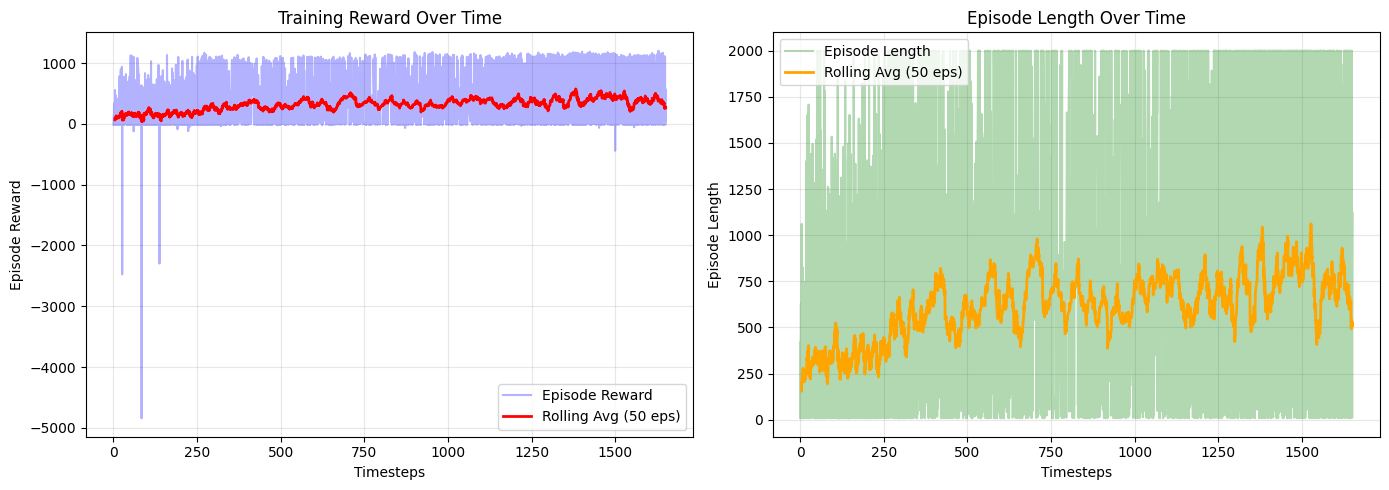

Training Summary:
Total episodes: 5586
Final avg reward (last 100 eps): 324.45
Max reward: 1444133.10
  Final avg length (last 100 eps): 611.8


In [22]:
walking_df = load_results(walking_log_dir)
importlib.reload(helpers)
helpers.plot_training_progress(walking_df)
helpers.print_training_summary(walking_df)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


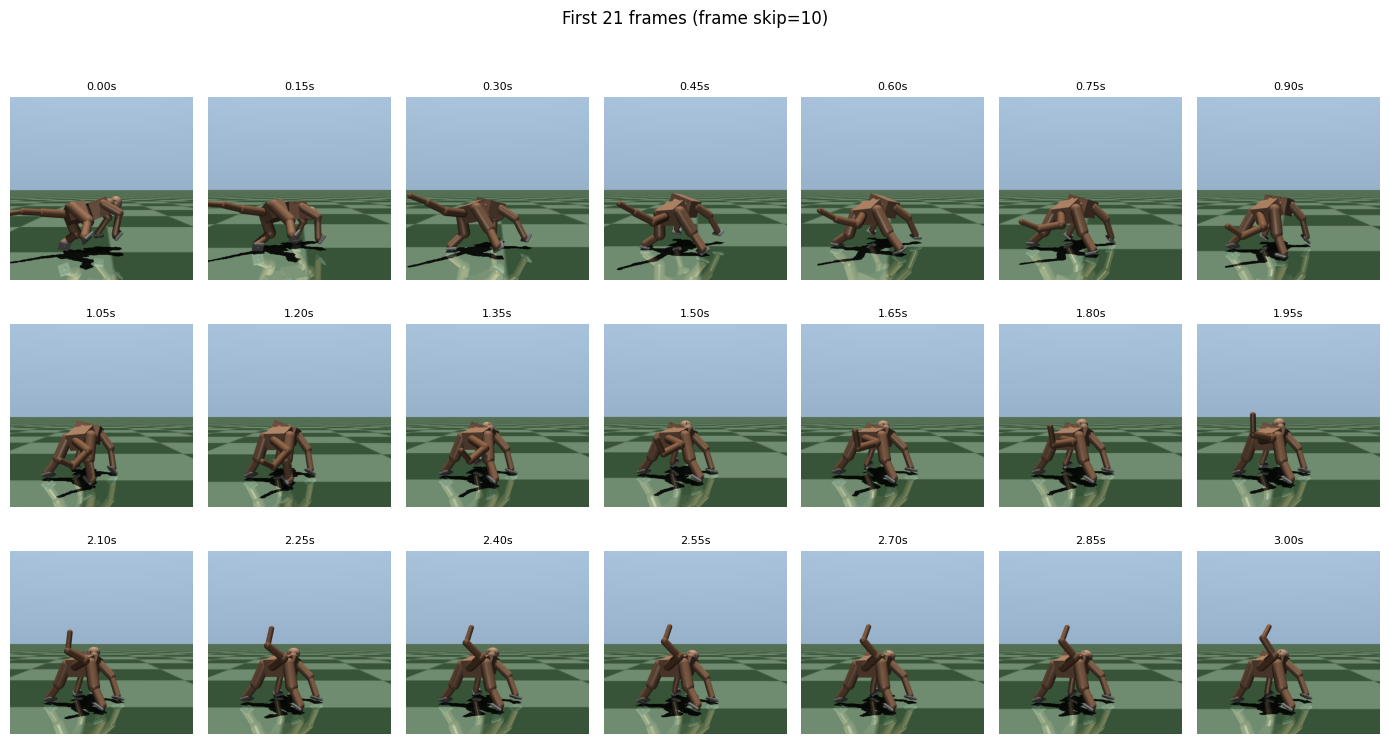

,time,chest_height,forward_velocity,forward_reward,gait_reward,stillness_reward,leg_pos_reward,height_dict,reward,cum_reward
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
1,0.15,0.165055,0.059921,-0.009360,0.0,-0.007357,0.063394,"{'chest': {'height': 0.16505530509015692, 'rew...",0.420882,5.730897
2,0.30,0.179678,-0.068205,-0.057488,0.0,-0.001653,0.071045,"{'chest': {'height': 0.17967803024720544, 'rew...",0.366816,10.723516
3,0.45,0.192389,0.103701,0.108906,0.0,-0.090966,0.070659,"{'chest': {'height': 0.19238932897602518, 'rew...",0.730742,16.710118
4,0.60,0.182383,0.251522,0.262083,0.0,-0.031259,0.069248,"{'chest': {'height': 0.18238322044392202, 'rew...",0.877764,25.611198
5,0.75,0.184239,0.072755,0.075841,0.0,-0.099937,0.069990,"{'chest': {'height': 0.18423870674138584, 'rew...",0.685691,32.027135
6,0.90,0.197113,0.039728,0.046143,0.0,-0.020871,0.072481,"{'chest': {'height': 0.19711313506745778, 'rew...",0.662526,38.632984
7,1.05,0.197102,0.018894,0.040391,0.0,-0.095203,0.074807,"{'chest': {'height': 0.19710191944337882, 'rew...",0.448971,44.017870
8,1.20,0.197667,-0.133340,-0.127625,0.0,-0.229255,0.076472,"{'chest': {'height': 0.19766681530579797, 'rew...",0.464384,47.695250
9,1.35,0.184888,0.022202,0.006176,0.0,-0.238686,0.074862,"{'chest': {'height': 0.18488809776911022, 'rew...",0.391604,53.119103


In [23]:
model = PPO.load(walking_model_path, env=make_walking_env())
importlib.reload(render_model_gym)
df = render_model_gym.display_test_env(
    make_walking_env(render_mode="rgb_array"),
    max_frames=21,
    frame_skip=10,
    attr_keys=walking_attrKeys + ["leg_pos_reward"],
    model=model,
)
plt.show()
display(df)

In [24]:
render_model_gym.render_model_gym(walking_model_path, xml_path)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Simulation dt: 0.0150s per step
Running simulation at 1.0x speed... Close the window to exit.


c:\GitHub\training-lucy\.venv\Lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)



Stopped by user
